## Initial Setup and EDA 

In [12]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# 2. Load Data
df = pd.read_csv('Churn_Modelling.csv')
print(f"Dataset shape: {df.shape}")
print(df.head())

# 3. Initial Exploration
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:", df.isnull().sum().sum())
print("\nChurn Rate:", df['Exited'].value_counts(normalize=True))

# 4. Drop unnecessary columns
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

Dataset shape: (10000, 14)
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826

## Deep EDA and Insight

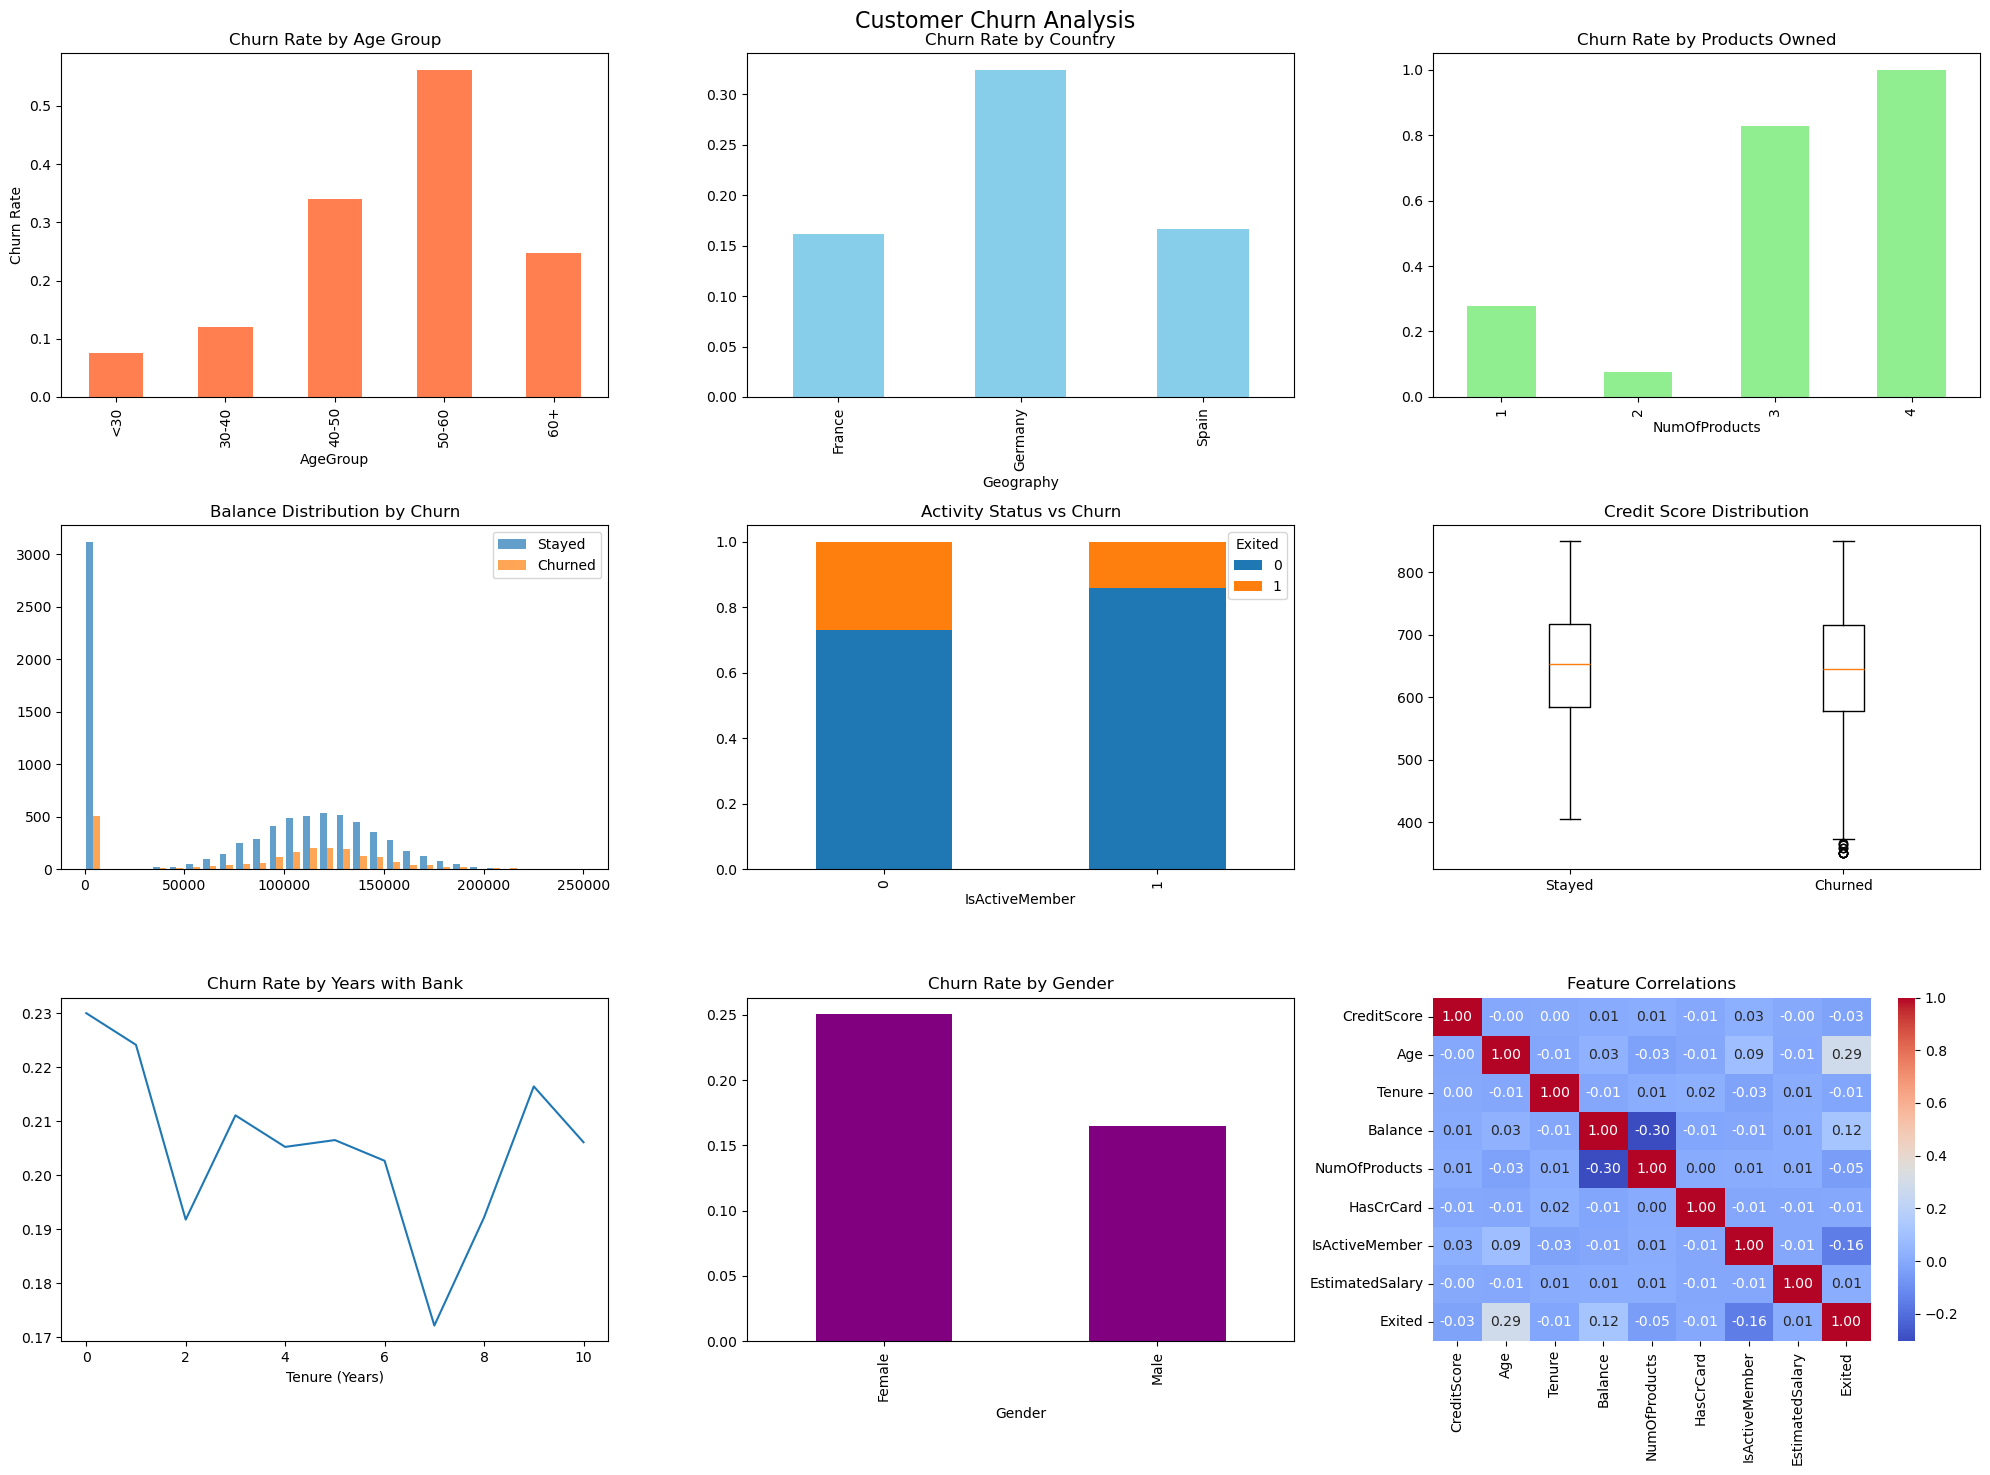

In [13]:
# Create visualization dashboard
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Customer Churn Analysis', fontsize=16)

# 1. Churn by Age Groups
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 30, 40, 50, 60, 100], 
                        labels=['<30', '30-40', '40-50', '50-60', '60+'])
churn_by_age = df.groupby('AgeGroup')['Exited'].mean()
churn_by_age.plot(kind='bar', ax=axes[0,0], color='coral')
axes[0,0].set_title('Churn Rate by Age Group')
axes[0,0].set_ylabel('Churn Rate')

# 2. Churn by Geography
churn_by_geo = df.groupby('Geography')['Exited'].mean()
churn_by_geo.plot(kind='bar', ax=axes[0,1], color='skyblue')
axes[0,1].set_title('Churn Rate by Country')

# 3. Churn by Number of Products
churn_by_products = df.groupby('NumOfProducts')['Exited'].mean()
churn_by_products.plot(kind='bar', ax=axes[0,2], color='lightgreen')
axes[0,2].set_title('Churn Rate by Products Owned')

# 4. Balance Distribution
axes[1,0].hist([df[df['Exited']==0]['Balance'], df[df['Exited']==1]['Balance']], 
               label=['Stayed', 'Churned'], bins=30, alpha=0.7)
axes[1,0].set_title('Balance Distribution by Churn')
axes[1,0].legend()

# 5. Churn by Activity Status
activity_churn = pd.crosstab(df['IsActiveMember'], df['Exited'], normalize='index')
activity_churn.plot(kind='bar', ax=axes[1,1], stacked=True)
axes[1,1].set_title('Activity Status vs Churn')

# 6. Credit Score Analysis
axes[1,2].boxplot([df[df['Exited']==0]['CreditScore'], 
                   df[df['Exited']==1]['CreditScore']], 
                  labels=['Stayed', 'Churned'])
axes[1,2].set_title('Credit Score Distribution')

# 7. Tenure Analysis
tenure_churn = df.groupby('Tenure')['Exited'].mean()
tenure_churn.plot(ax=axes[2,0])
axes[2,0].set_title('Churn Rate by Years with Bank')
axes[2,0].set_xlabel('Tenure (Years)')

# 8. Gender Analysis
gender_churn = df.groupby('Gender')['Exited'].mean()
gender_churn.plot(kind='bar', ax=axes[2,1], color='purple')
axes[2,1].set_title('Churn Rate by Gender')

# 9. Correlation Heatmap
corr_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', ax=axes[2,2], cmap='coolwarm')
axes[2,2].set_title('Feature Correlations')

plt.tight_layout()
plt.show()

## Feature Engineering 

In [14]:
def create_features(df):
    """Create business-meaningful features"""
    df = df.copy()
    
    # 1. Balance-related features
    df['BalancePerProduct'] = df['Balance'] / (df['NumOfProducts'] + 1)
    df['BalanceSalaryRatio'] = df['Balance'] / (df['EstimatedSalary'] + 1)
    df['HasBalance'] = (df['Balance'] > 0).astype(int)
    
    # 2. Customer value features
    df['TotalRelationshipValue'] = df['Balance'] + df['EstimatedSalary']
    df['ProductsPerTenure'] = df['NumOfProducts'] / (df['Tenure'] + 1)
    
    # 3. Age-related features
    df['AgePerTenure'] = df['Age'] / (df['Tenure'] + 1)
    df['IsYoung'] = (df['Age'] < 30).astype(int)
    df['IsSenior'] = (df['Age'] > 60).astype(int)
    
    # 4. Engagement Score
    df['EngagementScore'] = (df['HasCrCard'] + 
                             df['IsActiveMember'] + 
                             (df['NumOfProducts'] > 1).astype(int))
    
    # 5. Risk Flags
    df['HighValueAtRisk'] = ((df['Balance'] > df['Balance'].quantile(0.75)) & 
                              (df['IsActiveMember'] == 0)).astype(int)
    df['MultiProductHolder'] = (df['NumOfProducts'] >= 3).astype(int)
    
    # 6. Credit Score Categories
    df['CreditScoreCategory'] = pd.cut(df['CreditScore'], 
                                       bins=[0, 580, 670, 740, 800, 1000],
                                       labels=['Poor', 'Fair', 'Good', 'VeryGood', 'Excellent'])
    
    return df

# Apply feature engineering
df_featured = create_features(df)
print("New features created:", df_featured.shape[1] - df.shape[1])

New features created: 12


## Data Preprocessing

In [15]:
def preprocess_data(df):
    """Prepare data for modeling"""
    
    # Encode categorical variables
    label_encoders = {}
    categorical_columns = ['Geography', 'Gender', 'CreditScoreCategory']
    
    for col in categorical_columns:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
    
    # Separate features and target
    X = df.drop(['Exited', 'AgeGroup'], axis=1, errors='ignore')
    y = df['Exited']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

X_train, X_test, y_train, y_test, scaler = preprocess_data(df_featured)
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Class distribution: {y_train.value_counts(normalize=True)}")

Training set: (8000, 22)
Test set: (2000, 22)
Class distribution: Exited
0    0.79625
1    0.20375
Name: proportion, dtype: float64


## Handle Imbalanced Data

In [16]:
# Apply SMOTE for balanced training
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print(f"After SMOTE: {y_train_balanced.value_counts()}")

After SMOTE: Exited
1    6370
0    6370
Name: count, dtype: int64


## Model Training & Evaluation

In [17]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate
results = {}
for name, model in models.items():
    # Train on balanced data
    model.fit(X_train_balanced, y_train_balanced)
    
    # Predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Evaluate
    roc_score = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'roc_auc': roc_score,
        'report': classification_report(y_test, y_pred, output_dict=True)
    }
    
    print(f"\n{name}:")
    print(f"ROC-AUC: {roc_score:.4f}")
    print(classification_report(y_test, y_pred))


Logistic Regression:
ROC-AUC: 0.8486
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1593
           1       0.45      0.75      0.56       407

    accuracy                           0.76      2000
   macro avg       0.69      0.76      0.70      2000
weighted avg       0.83      0.76      0.78      2000


Random Forest:
ROC-AUC: 0.8516
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1593
           1       0.57      0.65      0.61       407

    accuracy                           0.83      2000
   macro avg       0.74      0.76      0.75      2000
weighted avg       0.84      0.83      0.83      2000


Gradient Boosting:
ROC-AUC: 0.8598
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1593
           1       0.62      0.63      0.63       407

    accuracy                           0.85      2000
   macro avg       0.7

## Ensemble Model

In [18]:
from sklearn.ensemble import VotingClassifier

# Create ensemble
ensemble = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=10)),
        ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ],
    voting='soft'
)

# Train ensemble
ensemble.fit(X_train_balanced, y_train_balanced)

# Evaluate
y_pred_ensemble = ensemble.predict(X_test)
y_pred_proba_ensemble = ensemble.predict_proba(X_test)[:, 1]

print("Ensemble Model Performance:")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_ensemble):.4f}")
print(classification_report(y_test, y_pred_ensemble))

Ensemble Model Performance:
ROC-AUC: 0.8607
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1593
           1       0.61      0.64      0.62       407

    accuracy                           0.84      2000
   macro avg       0.76      0.77      0.76      2000
weighted avg       0.84      0.84      0.84      2000

